# FlemishFish: Solving Various Forms of the Poisson Equation 

## Import Packages 

In [2]:
using StaticArrays 
using SparseArrays
using LinearAlgebra 
using BenchmarkTools
using Plots 

## Section 1: Introduction  

Solves various forms of the Poisson equation on the interval (i.e. in 1D), on the rectangle (i.e. in 2D) or on the cube (i.e. in 3D) using the central second order finite difference method on an uniform mesh. 

### To do 
1. test code for <b>type-stability</b> uing @inferred, JET.jl, DispatchDoctor.jl  or similar;
2. include a list of source functions, boundary conditions and analytical reference solutions;
3. include test that truncation error is zero for polynomials up to order 4; 
4. test code for results generated using a <b>mesh convergence</b> analysis; 

## Section 2:  Entire Code

In [3]:
const Point2D = SVector{2,Float64};

@enum bcType begin
           dirichlet    = 1
           neumann      = 2     
           periodic     = 3
           antiperiodic = 4 
       end

struct bcPatch
    bctype::bcType     # type of boundary condition being used 
    bcvalue::Float64   # value of boundary condition being used
end

In [4]:
""" 
Generates a one-dimensional uniform mesh between point 0 and 1

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int})`](@ref)
"""
function fdmmesh(N::NTuple{1,Int})
    m = tuple(range(0,1,length=N[1]+1))  
end

"""
Generates a one-dimensional uniform mesh between point a and b

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int},::Real,::Real)`](@ref)
"""
function fdmmesh(N::NTuple{1,Int},a::Real,b::Real)
    if (a>=b)
        ErrorException("Wrong input")
    else 
        m = tuple(range(a,b,length=N+1)) 
    end 
end 

"""
Generates a two-dimensional mesh between the points (0,0) and (1,1) 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int})`](@ref)
"""
function fdmmesh(N::NTuple{2,Int})
    m = (range(0,1,length=N[1]+1),range(0,1,length=N[2]+1))
end 

""" 
Generates a two-dimensional mesh between the points a and b 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int},::Point2D,::Point2D)`](@ref)
"""
function fdmmesh(N::NTuple{2,Int}, a::Point2D,b::Point2D)
    if ((a.x>=b.x)||(a.y>=b.y))
        ErrorException("Wrong input")
    else         
        m = (range(a.x,b.x,length=N[1]+1),range(a.y,b.y,length=N[2]+1))
    end 
end

"""
Generates a vector on a one-dimensional uniform mesh by nodal evaluation a function
"""
function loadvec(mesh::NTuple{1,AbstractRange},sourceFct::Function)  
    f = sourceFct.(mesh[1])
    return f      
end

""" 
Generates a vector on a two-dimensional uniform mesh by nodal evaluation a function
Remark: we deliberately store the vector as a 2D array to facilitate the setting on boundary conditions 
"""
function loadvec(mesh::NTuple{2,AbstractRange},sourceFct::Function)  
    f = vec(sourceFct.(mesh[1], mesh[2]')) 
    return f      
end

"""
Generates the one-dimensional diffusion or graph Laplacian matrix 

Input r is the one-dimensional mesh. 
Output A is the one-dimensional diffusion matrix with stencil (1/h2)*[-1 2 -1]. 
Remark: we deliberately convert from Tridiagonal to sparse to allow for periodic boundary conditions at later stage.
""" 
function stiffmat(mesh::NTuple{1,AbstractRange})
    xm = mesh[1]
    Np1 = length(xm)
    N = Np1-1; h = abs(xm[end] - xm[1])/N; h2 = h*h
    e = ones(Np1) 
    A = spdiagm(-1 => -e[2:end], 0 => 2*e, 1 => -e[2:end])
    A = (1/h2)*A
    return A     
end

"""
Generates the one-dimensional convection-diffusion matrix 

Input mesh is the one-dimensional mesh. 
Output A is the one-dimensional diffusion matrix with stencil (1/h)*[0 -1 1]. 
""" 
function convectionmat(mesh::NTuple{1,AbstractRange})
    xm = mesh[1]
    Np1 = length(xm)
    N = Np1-1; h = abs(xm[end] - xm[1])/N
    e = ones(Np1) 
    A = spdiagm(0 => -e, 1 => e[2:end])
    A = (1/h)*A
    return A     
end

""" 
Generates the two-dimensional diffusion or graph Laplacian matrix 
""" 
function stiffmat(mesh::NTuple{2,AbstractRange})
    xm = mesh[1]; ym = mesh[2]  
    Nxp1 = length(xm); Nyp1 = length(ym);   
    #..contribution in x-direction 
    A1Dxx = stiffmat(tuple(xm))
    A2Dxx = kron(A1Dxx,I(Nyp1))
    #..contribution in y-direction
    A1Dyy = stiffmat(tuple(ym))
    A2Dyy = kron(I(Nxp1),A1Dyy)
    #..sum of x-direction and y-direction contribution 
    A = A2Dxx + A2Dyy
    return A 
end

""" 
Generates boundary condition entries for matrix A and right-hand side vector f 
Remark: after treatment of boundary conditions, the matrix is no longer symmetric. 
"""
function applybc!(mesh::NTuple{1,AbstractRange},bc::NTuple{2,bcPatch},A,f)
 
    #..retrieve mesh information
    xm = mesh[1];
    Np1 = length(xm)
    N = Np1-1; h = abs(xm[end] - xm[1])/N; h2 = h*h
    
    #..treat coupled boundary conditions 
    patch = bc[1]
    if (patch.bctype==bcType(3))
        A = sparse(A)
        A[1,end-1] = -1/h2
        A[end,2]   = -1/h2 
        return A,f 
    end 
            
    #..treatment of left bc 
    patch = bc[1]           
    if (patch.bctype==bcType(1)) 
        A[1,1] = 1.; A[1,2] = 0. 
        f[1] = patch.bcvalue
    elseif (patch.bctype==bcType(2))
        A[1,1] = 1/h ;  A[1,2] = -1/h
        f[1] = patch.bcvalue 
    else
         error(" handle_bc!:: Error:: Left boundary conditions not set")           
    end 

    #..treatment of right bc 
    patch = bc[2]           
    if (patch.bctype==bcType(1)) 
        A[end,end] = 1.; A[end,end-1] = 0. 
        f[end] = patch.bcvalue
    elseif (patch.bctype==bcType(2))
        A[end,end] = 1/h ;  A[end,end-1] = -1/h 
        f[end] = patch.bcvalue 
    else
         error(" handle_bc!:: Error:: Right boundary conditions not set")           
    end 
        
    return A,f  

end

function applybc!(mesh::NTuple{2,AbstractRange},bc::NTuple{4,bcPatch},A,f)

    # requires chechking what is x and y
    Nxp1 = length(mesh[1])
    Nyp1 = length(mesh[2])
    linear = LinearIndices((1:Nxp1, 1:Nyp1)) 
    
    #..treatment of bottom bc from left to right 
    patch = bc[1]  
    for i in 1:Nxp1 
        I = linear[i,1]
        f[I] = patch.bcvalue 
        A[I,:] .= 0.; A[I,I] = 1.
    end

    #..treatment of right bc from bottom to top 
    patch = bc[2]           
    for j = 1:Nyp1  
        I = linear[Nxp1,j]
        f[I] = patch.bcvalue 
        A[I,:] .= 0.; A[I,I] = 1.       
    end
        
    #..treatment of top bc from left to right
    patch = bc[3]           
    for i in 1:Nxp1
        I = linear[i,Nyp1]
        f[I] = patch.bcvalue 
        A[I,:] .= 0.; A[I,I] = 1.       
    end
        
    #..treatment of left bc from bottom to top
    patch = bc[4]           
    for j = 1:Nyp1
        I = linear[1,j]
        f[I] = patch.bcvalue 
        A[I,:] .= 0.; A[I,I] = 1.        
    end
    
    return A,f 
        
end 

""" 
Generates discrete solution vector u   
"""
function solve(A,f)
    u = A\f 
    return u 
end

;

## Section 3: Unit Tests for the 1D Code   

In [5]:
#..(1/) Set the problem by setting the source function and the boundary conditions 
#....set the source function....
fct(x) = x^2
#....set the boundary conditions for the left and right boundary patch  
leftbcpatch  = bcPatch(bcType(1),0.)
rightbcpatch = bcPatch(bcType(2),1.)  
bc = (leftbcpatch,rightbcpatch) 

(bcPatch(dirichlet, 0.0), bcPatch(neumann, 1.0))

In [6]:
?fdmmesh

search: fdmmesh



Generates a one-dimensional uniform mesh between point 0 and 1

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int})`](@ref)

---

Generates a one-dimensional uniform mesh between point a and b

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int},::Real,::Real)`](@ref)

---

Generates a two-dimensional mesh between the points (0,0) and (1,1) 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int})`](@ref)

---

Generates a two-dimensional mesh between the points a and b 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int},::Point2D,::Point2D)`](@ref)


In [7]:
N = (10,); 
@code_warntype fdmmesh(N)

MethodInstance for fdmmesh(::Tuple{Int64})
  from fdmmesh(N::Tuple{Int64}) in Main at In[4]:8
Arguments
  #self#::Core.Const(fdmmesh)
  N::Tuple{Int64}
Locals
  m::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
Body::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
1 ─ %1 = Base.getindex(N, 1)::Int64
│   %2 = (%1 + 1)::Int64
│   %3 = (:length,)::Core.Const((:length,))
│   %4 = Core.apply_type(Core.NamedTuple, %3)::Core.Const(NamedTuple{(:length,)})
│   %5 = Core.tuple(%2)::Tuple{Int64}
│   %6 = (%4)(%5)::NamedTuple{(:length,), Tuple{Int64}}
│   %7 = Core.kwfunc(Main.range)::Core.Const(Base.var"#range##kw"())
│   %8 = (%7)(%6, Main.range, 0, 1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│   %9 = Main.tuple(%8)::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
│        (m = %9)
└──      return %9



In [8]:
N = (10,); @btime m = fdmmesh(N)

  65.799 ns (0 allocations: 0 bytes)


(0.0:0.1:1.0,)

In [9]:
typeof(m)

LoadError: UndefVarError: m not defined

In [10]:
N = (10,); m = fdmmesh(N); 
@code_warntype stiffmat(m);

MethodInstance for stiffmat(::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}})
  from stiffmat(mesh::Tuple{AbstractRange}) in Main at In[4]:77
Arguments
  #self#::Core.Const(stiffmat)
  mesh::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
Locals
  A::SparseMatrixCSC{Float64, Int64}
  e::Vector{Float64}
  h2::Float64
  h::Float64
  N::Int64
  Np1::Int64
  xm::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
Body::SparseMatrixCSC{Float64, Int64}
1 ─       (xm = Base.getindex(mesh, 1))
│         (Np1 = Main.length(xm))
│         (N = Np1 - 1)
│   %4  = xm::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│   %5  = Base.lastindex(xm)::Int64
│   %6  = Base.getindex(%4, %5)::Float64
│   %7  = Base.getindex(xm, 1)::Float64
│   %8  = (%6 - %7)::Float64
│   %9  = Main.abs(%8)::Float64
│         (h = %9 / N)
│         (h2

In [11]:
N = (10,); m = fdmmesh(N); @btime A = stiffmat(m);

  1.981 μs (39 allocations: 4.86 KiB)


In [12]:
N = (10,); m = fdmmesh(N);
@code_warntype loadvec(m,fct)

MethodInstance for loadvec(::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, ::typeof(fct))
  from loadvec(mesh::Tuple{AbstractRange}, sourceFct::Function) in Main at In[4]:56
Arguments
  #self#::Core.Const(loadvec)
  mesh::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  sourceFct::Core.Const(fct)
Locals
  f::Vector{Float64}
Body::Vector{Float64}
1 ─ %1 = Base.getindex(mesh, 1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│   %2 = Base.broadcasted(sourceFct, %1)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(fct), Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
│        (f = Base.materialize(%2))
└──      return f



In [13]:
N = (10,); m = fdmmesh(N); @btime loadvec(m,fct); 

  420.648 ns (4 allocations: 336 bytes)


In [14]:
N = (10,); m = fdmmesh(N); A = stiffmat(m); f = loadvec(m,fct);
@code_warntype applybc!(m,bc,A,f)

MethodInstance for applybc!(::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, ::Tuple{bcPatch, bcPatch}, ::SparseMatrixCSC{Float64, Int64}, ::Vector{Float64})
  from applybc!(mesh::Tuple{AbstractRange}, bc::Tuple{bcPatch, bcPatch}, A, f) in Main at In[4]:124
Arguments
  #self#::Core.Const(applybc!)
  mesh::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  bc::Tuple{bcPatch, bcPatch}
  A@_4::SparseMatrixCSC{Float64, Int64}
  f::Vector{Float64}
Locals
  patch::bcPatch
  h2::Float64
  h::Float64
  N::Int64
  Np1::Int64
  xm::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  A@_12::SparseMatrixCSC{Float64, Int64}
Body::Tuple{SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
1 ──       (A@_12 = A@_4)
│          (xm = Base.getindex(mesh, 1))
│          (Np1 = Main.length(xm))
│          (N = Np1 - 1)
│    %5  = xm::StepRangeLen{Float64, Base.TwicePrecision

In [15]:
?applybc!

search: applybc!



Generates boundary condition entries for matrix A and right-hand side vector f  Remark: after treatment of boundary conditions, the matrix is no longer symmetric. 


In [16]:
N = (10,); m = fdmmesh(N); 
leftbcpatch  = bcPatch(bcType(1),0.)
rightbcpatch = bcPatch(bcType(1),1.)  
bc = (leftbcpatch,rightbcpatch) 
A = stiffmat(m); f = loadvec(m,fct);
@btime applybc!(m,bc,A,f); 

  86.315 ns (1 allocation: 64 bytes)


In [17]:
N = (10,); m = fdmmesh(N); 
leftbcpatch  = bcPatch(bcType(1),0.)
rightbcpatch = bcPatch(bcType(1),1.)  
bc = (leftbcpatch,rightbcpatch) 
A = stiffmat(m); f = loadvec(m,fct); A,f = applybc!(m,bc,A,f); 
@code_warntype solve(A,f)

MethodInstance for solve(::SparseMatrixCSC{Float64, Int64}, ::Vector{Float64})
  from solve(A, f) in Main at In[4]:214
Arguments
  #self#::Core.Const(solve)
  A::SparseMatrixCSC{Float64, Int64}
  f::Vector{Float64}
Locals
  u::Vector{Float64}
Body::Vector{Float64}
1 ─     (u = A \ f)
└──     return u



In [18]:
N = (1000,); m = fdmmesh(N); 
leftbcpatch  = bcPatch(bcType(1),0.)
rightbcpatch = bcPatch(bcType(1),1.)
A = stiffmat(m); f = loadvec(m,fct); A,f = applybc!(m,bc,A,f); 
@btime solve(A,f);

  331.125 μs (69 allocations: 1.06 MiB)


### Trying Alternative Tools for the Test  

In [19]:
using Test 

In [20]:
@inferred fdmmesh(N)

(0.0:0.001:1.0,)

## Section 4: Testing Functionality for 1D Diffusion Problem 

<b>Problem to solve</b> Assume $x \in \Omega=(0,1)$. We intend to solve $-u''(x) = f(x)$ supplied with appropriate boundary conditions. 

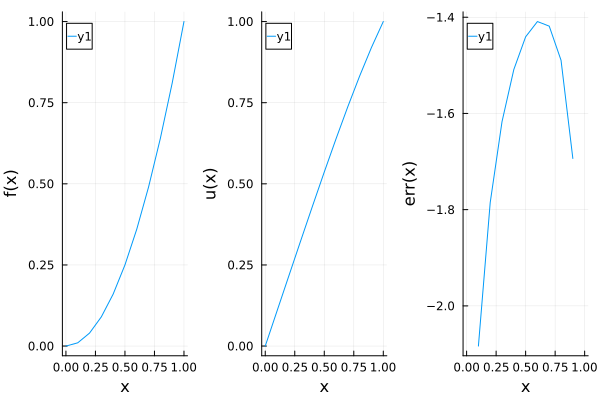

In [21]:
#..(1/) Set the problem by setting the source function and the boundary conditions 
#....set the source function....
fct(x) = x^2
#....set the boundary conditions for the left and right boundary patch  
leftbcpatch  = bcPatch(bcType(1),0.)
rightbcpatch = bcPatch(bcType(1),1.)  
bc = (leftbcpatch,rightbcpatch) 

#..(2/) Set exact solution as a reference 
uefct(x) = x 

#..(3/) Generate the mesh with N intervals and N+1 nodes 
N = (10,)
m = fdmmesh(N)

#..(4/) Generate the matrix 
A = stiffmat(m)

#..(5/) Generate the right-hand side vector 
f = loadvec(m,fct) 

#..(6/) Apply the boundary conditions 
A, f = applybc!(m,bc,A,f)

#..(7/) Generate the solution 
u = solve(A,f)

#..(8/) Generate the solution
ue = uefct.(m[1])
er = u - ue 

#..(9/) Plot the source function, the solution and error  
p1 = plot(m,f,xlabel="x",ylabel = "f(x)")
p2 = plot(m,u,xlabel="x",ylabel = "u(x)")
p3 = plot(m,log10.(abs.(er)),xlabel="x",ylabel = "err(x)")
plot(p1,p2,p3,layout = (1,3))

## Section 5: Testing Functionality for 1D Convection - Diffusion Problem 

<b>Problem to solve</b> Assume $x \in \Omega=(0,1)$ and that the Peclet number $\epsilon > 0$. We intend to solve 

$$
\epsilon \, u''(x) - u'(x) = 0 
$$

supplied with Dirichlet boundary conditions $u(x=0) = 0$ and $u(x=1) = 1$. 

<b>Analytical Solution</b> This problem has the analytical solution 

$$
u^e(x) = (\exp(x/\epsilon) - 1)/ (\exp(1/\epsilon) - 1) \, . 
$$ 

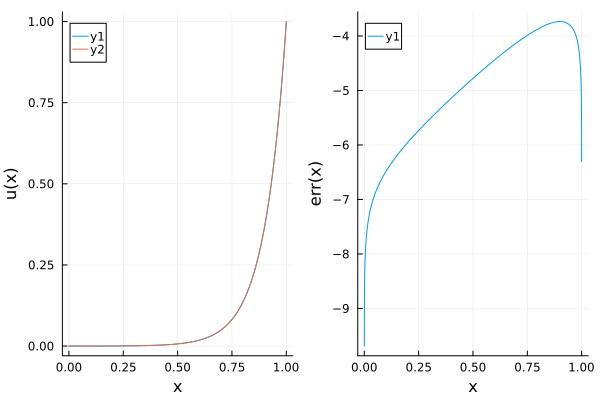

In [29]:
#..(1/) Set the problem by setting the source function and the boundary conditions 
#....set the source function....
fct(x) = 0.
#....set the boundary conditions for the left and right boundary patch  
leftbcpatch  = bcPatch(bcType(1),0.)
rightbcpatch = bcPatch(bcType(1),1.)  
bc = (leftbcpatch,rightbcpatch) 

#..(2/) Set value for Peclet number epsilon 
epsilon = 0.1

#..(3/) Set exact solution as a reference 
uefct(x) = (exp(x/epsilon) - 1) / (exp(1/epsilon) - 1)

#..(4/) Generate the mesh with N intervals and N+1 nodes 
N = (10000,)
m = fdmmesh(N)

#..(5/) Generate the diffusion matrix 
A = stiffmat(m)

#..(6/) Generate the convection matrix 
C = convectionmat(m)

A = epsilon*A + C

#..(7/) Generate the right-hand side vector 
f = loadvec(m,fct) 

#..(8/) Apply the boundary conditions 
A, f = applybc!(m,bc,A,f)

#..(8/) Generate the solution 
u = solve(A,f)

#..(8/) Generate the solution
ue = uefct.(m[1])
er = u - ue 

#..(9/) Plot the source function, the solution and error  
p1 = plot(m,ue,xlabel="x",ylabel = "ue(x)")
p1 = plot!(m,u,xlabel="x",ylabel = "u(x)")
p2 = plot(m,log10.(abs.(er)),xlabel="x",ylabel = "err(x)")
plot(p1,p2,layout = (1,2))

## Section 6: Testing Functionality for 2D Problem

In [30]:
#..(1/) Set the problem by setting the source function and the boundary conditions 
#....set the source function....
fct(x,y) = x+y
#....set the boundary conditions for the left and right boundary patch  
bottombcpatch = bcPatch(bcType(1),0.)
rightbcpatch  = bcPatch(bcType(1),1.) 
topbcpatch    = bcPatch(bcType(1),2.)
leftbcpatch   = bcPatch(bcType(1),3.)
bc = (bottombcpatch, rightbcpatch, topbcpatch, leftbcpatch,) 

#..(2/) Generate the mesh with N intervals and N+1 nodes 
nx = 30; ny = 30; N = (nx,ny)
@code_warntype fdmmesh(N)

MethodInstance for fdmmesh(::Tuple{Int64, Int64})
  from fdmmesh(N::Tuple{Int64, Int64}) in Main at In[5]:34
Arguments
  #self#::Core.Const(fdmmesh)
  N::Tuple{Int64, Int64}
Locals
  m::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
Body::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
1 ─ %1  = Base.getindex(N, 1)::Int64
│   %2  = (%1 + 1)::Int64
│   %3  = (:length,)::Core.Const((:length,))
│   %4  = Core.apply_type(Core.NamedTuple, %3)::Core.Const(NamedTuple{(:length,)})
│   %5  = Core.tuple(%2)::Tuple{Int64}
│   %6  = (%4)(%5)::NamedTuple{(:length,), Tuple{Int64}}
│   %7  = Core.kwfunc(Main.range)::Core.Const(Base.var"#range##kw"())
│   %8  = (%7)(%6, Main.range, 0, 1)::StepRangeLen{Float64, Base.TwicePrecision

In [31]:
nx = 30; ny = 30; N = (nx,ny); m = fdmmesh(N)
stiffmat(m)

961×961 SparseMatrixCSC{Float64, Int64} with 4681 stored entries:
⣻⢞⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣟⣽⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣟⣽⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣿⣿⣦⡀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⡵⣯

In [32]:
nx = 30; ny = 30; N = (nx,ny); m = fdmmesh(N)
@code_warntype loadvec(m,fct)

MethodInstance for loadvec(::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, ::typeof(fct))
  from loadvec(mesh::Tuple{AbstractRange, AbstractRange}, sourceFct::Function) in Main at In[5]:65
Arguments
  #self#::Core.Const(loadvec)
  mesh::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  sourceFct::Core.Const(fct)
Locals
  f::Vector{Float64}
Body::Vector{Float64}
1 ─ %1 = Base.getindex(mesh, 1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│   %2 = Base.getindex(mesh, 2)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│   %3 = Main.:var"'"(%2)::Adjoint{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecisi

In [33]:
nx = 30; ny = 30; N = (nx,ny); m = fdmmesh(N)
bottombcpatch = bcPatch(bcType(1),1.)
rightbcpatch  = bcPatch(bcType(1),1.) 
topbcpatch    = bcPatch(bcType(1),1.)
leftbcpatch   = bcPatch(bcType(1),1.)
A = stiffmat(m); f = loadvec(m,fct)
@code_warntype applybc!(m,bc,A,f)

MethodInstance for applybc!(::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, ::NTuple{4, bcPatch}, ::SparseMatrixCSC{Float64, Int64}, ::Vector{Float64})
  from applybc!(mesh::Tuple{AbstractRange, AbstractRange}, bc::NTuple{4, bcPatch}, A, f) in Main at In[5]:152
Arguments
  #self#::Core.Const(applybc!)
  mesh::Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  bc::NTuple{4, bcPatch}
  A::SparseMatrixCSC{Float64, Int64}
  f::Vector{Float64}
Locals
  @_6::Union{Nothing, Tuple{Int64, Int64}}
  @_7::Union{Nothing, Tuple{Int64, Int64}}
  @_8::Union{Nothing, Tuple{Int64, Int64}}
  @_9::Union{Nothing, Tuple{Int64, Int64}}
  patch::bcPatch
  linear::LinearIndices{2, Tuple{UnitRange{Int64}, UnitRange{Int64}}}
  Nyp1::Int64

## Section 7: Testing Functionality for 2D Problem

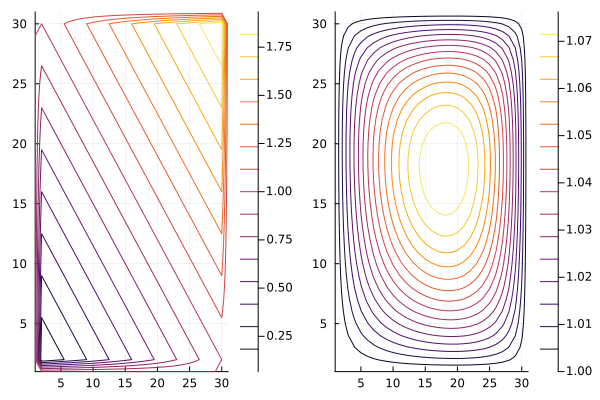

In [34]:
#..(1/) Set the problem by setting the source function and the boundary conditions 
#....set the source function....
fct(x,y) = x+y
#....set the boundary conditions for the left and right boundary patch  
bottombcpatch = bcPatch(bcType(1),1.)
rightbcpatch  = bcPatch(bcType(1),1.) 
topbcpatch    = bcPatch(bcType(1),1.)
leftbcpatch   = bcPatch(bcType(1),1.)
bc = (bottombcpatch, rightbcpatch, topbcpatch, leftbcpatch,) 

#..(2/) Set exact solution as a reference 
uefct(x,y) = 1

#..(3/) Generate the mesh with N intervals and N+1 nodes 
nx = 30; ny = 30; N = (nx,ny)
m = fdmmesh(N)

#..(4/) Generate the matrix 
A = stiffmat(m)

#..(5/) Generate the right-hand side vector 
f = loadvec(m,fct) 

#..(6/) Apply the boundary conditions 
A, f = applybc!(m,bc,A,f)

#..(7/) Generate the solution 
u = solve(A,f)

#..(9/) Plot the solution 
p1 = contour(reshape(f,nx+1,ny+1))
p2 = contour(reshape(u,nx+1,ny+1)) 
plot(p1,p2,layout = (1,2))

## Modify Vector in 2D to Accomodate Boundary Conditions  
### How to modify f in nodes corresponding to the boundary? 

In [35]:
fct2(x,y) = x+y

fct2 (generic function with 1 method)

mesh = gen_mesh((3,3))

In [36]:
f2 = loadvec(mesh,fct2)
f2[:,1] .= 0
display(f2)

LoadError: UndefVarError: mesh not defined

### How to modify the  matrix to accomode the boundary conditions 
A[I,:] .= 0 and A[I,I] = 1 for I linear index of a boundary node. 

In [ ]:
linear = LinearIndices((1:4, 1:4))
for (i,x) in enumerate(mesh[1]) 
    I = linear[i,1]
    display(I)
end 

In [ ]:
?LinearIndices

In [ ]:
?CartesianIndices

In [ ]:
mesh = gen_mesh((3,3))
foo = LinearIndices((1:4,1:4))
boundary_foo = [foo[1,:] ; foo[end,:] ; foo[:,1]; foo[:,end] ] 
# boundary_foo = [foo[1,:] foo[end,:]]

In [ ]:
# Q1: how to find indices on fvec that correspond to start/end point of xvec/yvec 
# Q2: how to overwrite values of fvec that correspond to start/end point of xvec/yvec 
foo(x,y) = x+y 
xvec = range(0,1,length=5)
yvec = range(0,1,length=5)
fvec = vec(foo.(xvec,yvec'))
linear = LinearIndices((1:5, 1:5))
leftInd = linear[1,1:5]

### To do
1. generate mesh; 
2. evaluate diffusion coefficient on the mesh; 
3. replace div*grad by div*D*grad 
4. test by capacitor plate problem; 

In [ ]:
N=9; Np1 = N+1; h = 1/N; 
B = sparse([i==j ? -1/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1])

In [ ]:
Bx = kron(B,I(Np1))
By = kron(I(Np1),B)
grad = [Bx; By]
div  = Transpose(grad)
A = div*grad 

## Section 8: Examples of Mesh Generation 

In [ ]:
?genMesh

In [ ]:
methods(genMesh)

### Section 1.8: Examples of 1D Mesh Generation 

In [ ]:
mesh1d = genMesh(5,1.,5.)

In [ ]:
typeof(mesh1d)

In [ ]:
isa(mesh1d,StepRangeLen)

### Section 2.8: Examples of 2D Mesh Generation 

In [ ]:
mesh2d = genMesh(5,Point2D(1.,1.),Point2D(5.,6.))

In [ ]:
typeof(mesh2d)

In [ ]:
isa(mesh2d,Tuple)

In [ ]:
length(mesh2d[1])

## Section 9: Generation of Vector

In [ ]:
fct1(x) = x[1]^2
fct2(x,y) = x+y

In [ ]:
methods(genVector)

### Section 1.9: Examples of 1D Vector Generation 

In [ ]:
f1 = genVec(mesh1d,fct1)

### Section 2.9: Examples of 2D Vector Generation 

In [ ]:
f2 = genVec(mesh2d[1],mesh2d[2],fct2)

## Section 10: Generation  of Stiffness Matrix 

In [ ]:
methods(genStiffMat)

### Section 1.10: Examples of 1D Matrix Generation 

In [ ]:
A1 = genStiffMat(mesh1d)

### Section 2.10: Examples of 2D Matrix Generation 

In [ ]:
A2 = genStiffMat(mesh2d[1],mesh2d[2])